<a href="https://colab.research.google.com/github/silvia-denanni/DI-Bootcamp-nov25/blob/main/W8D2DailyChallengeWebScrapingVisualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1) Scrape the Webpage:
- Use Python libraries like Selenium to interact with the webpage and BeautifulSoup to parse the HTML,
- Extract relevant data such as dates, numerical values, categories, etc.,
- Organize the scraped data into a structured format.

In [9]:
import sys
!{sys.executable} -m pip install selenium beautifulsoup4 webdriver_manager

# Install Chrome browser
!apt-get update
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!dpkg -i google-chrome-stable_current_amd64.deb
!apt-get install -f # Install dependencies if any

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time
from webdriver_manager.chrome import ChromeDriverManager

# Setup Selenium WebDriver (Chrome example)
# Use ChromeDriverManager to automatically handle chromedriver installation
service = Service(ChromeDriverManager().install())
options = webdriver.ChromeOptions()
options.add_argument('--headless')  # Run headless browser (optional)
options.add_argument('--no-sandbox') # Required for running Chrome in some environments like Colab
options.add_argument('--disable-dev-shm-usage') # Required for running Chrome in some environments like Colab
driver = webdriver.Chrome(service=service, options=options)

try:
    url = 'https://www.bbc.com/weather/293397'
    driver.get(url)

    # Debugging: Print current URL and entire page source for inspection
    print(f"Current URL: {driver.current_url}")
    print("Page Source (full):\n", driver.page_source)

    # Wait for the main weather container to load (adjust selector if needed)
    wait = WebDriverWait(driver, 20) # 20 sec timeout for better loading
    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'li.wr-day')))

    # Optional: wait a bit more to ensure all dynamic content loads
    time.sleep(3)

    # Get the fully rendered page source
    html = driver.page_source

    # Parse with BeautifulSoup
    soup = BeautifulSoup(html, 'html.parser')

    # Container for all days (including current and forecast)
    days = soup.select('li.wr-day')

    weather_data = []

    for day in days:
        # Extract full date (e.g., "Tue 30th")
        date_span = day.select_one('span.wr-date__longish')
        if date_span:
            # Get text including nested spans, join with no extra spaces
            date_text = ''.join(date_span.stripped_strings)
        else:
            date_text = 'N/A'

        # Extract temperatures
        # High temperature (may not exist for current day)
        high_temp_span = day.select_one('div.wr-day-temperature__high span.wr-value--temperature--c')
        high_temp = high_temp_span.text if high_temp_span else 'N/A'

        # Low temperature
        low_temp_span = day.select_one('div.wr-day-temperature__low span.wr-value--temperature--c')
        low_temp = low_temp_span.text if low_temp_span else 'N/A'

        # Extract label for current day (e.g., "Tonight", "Monday 29th December")
        title_div = day.select_one('div.wr-day__title')
        day_label = title_div.get_text(strip=True) if title_div else ''

        weather_data.append({
            'date': date_text,
            'day_label': day_label,
            'high_temp_c': high_temp,
            'low_temp_c': low_temp
        })

    # Print extracted weather data
    for entry in weather_data:
        print(f"Date: {entry['date']}, Label: {entry['day_label']}, High: {entry['high_temp_c']}, Low: {entry['low_temp_c']}")

finally:
    driver.quit()


Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://dl.google.com/linux/chrome/deb stable InRelease
Get:3 https://cli.github.com/packages stable InRelease [3,917 B]
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Fetched 3,917 B in 1s (3,053 B/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
--2025-12-30 00:01:23--  https://dl.google.com/linux/direct/google-chrome-stable_cur

#2. Data Analysis with Pandas:

Load your scraped data into a Pandas DataFrame.

Clean and preprocess the data if necessary (handling missing values, type conversion, etc.).

Perform basic analysis, such as calculating averages, totals, or trends over time.


In [10]:
import pandas as pd

# Load the scraped data into a Pandas DataFrame
df = pd.DataFrame(weather_data)

# Display the first few rows of the DataFrame
display(df.head())

# Display data types and non-null values to assess data quality
df.info()

,date,day_label,high_temp_c,low_temp_c
0,N/A,Tonight,N/A,15°
1,Tue30th,Tuesday30thDecemberTue30th,19°,13°
2,Wed31st,Wednesday31stDecemberWed31st,20°,13°
3,Thu1st,Thursday1stJanuaryThu1st,18°,13°
4,Fri2nd,Friday2ndJanuaryFri2nd,17°,9°


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         14 non-null     object
 1   day_label    14 non-null     object
 2   high_temp_c  14 non-null     object
 3   low_temp_c   14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes


In [14]:
import numpy as np # Import numpy for np.nan

# Define a helper function to safely clean and convert temperature columns
def clean_temperature_column_robust(series):
    # Only apply string operations if the column is of object (string) dtype
    if pd.api.types.is_object_dtype(series):
        series = series.str.replace('°', '', regex=False)
        series = series.replace('N/A', np.nan) # Use np.nan instead of pd.NA for broader compatibility

    # Convert to numeric, coercing errors to NaN
    series = pd.to_numeric(series, errors='coerce')
    return series

# Apply the cleaning and conversion function to the temperature columns
df['high_temp_c'] = clean_temperature_column_robust(df['high_temp_c'])
df['low_temp_c'] = clean_temperature_column_robust(df['low_temp_c'])

# Fill missing values with the mean and round
# Calculate mean before filling to ensure it's based on existing numeric values
mean_high_temp = df['high_temp_c'].mean()
mean_low_temp = df['low_temp_c'].mean()

df['high_temp_c'] = df['high_temp_c'].fillna(mean_high_temp).round(2)
df['low_temp_c'] = df['low_temp_c'].fillna(mean_low_temp).round(2)

# Display updated DataFrame info and head to verify changes
display(df.head())
df.info()

,date,day_label,high_temp_c,low_temp_c
0,N/A,Tonight,19.23,15
1,Tue30th,Tuesday30thDecemberTue30th,19.00,13
2,Wed31st,Wednesday31stDecemberWed31st,20.00,13
3,Thu1st,Thursday1stJanuaryThu1st,18.00,13
4,Fri2nd,Friday2ndJanuaryFri2nd,17.00,9


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         14 non-null     object 
 1   day_label    14 non-null     object 
 2   high_temp_c  14 non-null     float64
 3   low_temp_c   14 non-null     int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 580.0+ bytes


In [21]:
df['date'] = df['date'].replace('N/A', 'Mon29th')

In [19]:
df['day_label'] = df['day_label'].replace('Tonight', 'Monday29thDecemberMon29th')

In [23]:
import re
from datetime import datetime, timedelta

# Define the starting date for the sequence based on the first entry (Monday, December 29, 2025)
start_date = datetime(2025, 12, 29)

# Generate a list of dates for the entire DataFrame length and format them
formatted_dates = []
for i in range(len(df)):
    current_date = start_date + timedelta(days=i)
    formatted_dates.append(current_date.strftime('%d/%m/%Y'))

# Assign the new formatted dates to the 'date' column
df['date'] = formatted_dates

# Function to extract only the day of the week from the 'day_label' column
def extract_day_of_week_from_label(label):
    # Extract the first alphabetic sequence from the label
    match = re.match(r'([A-Za-z]+)', label)
    if match:
        return match.group(1)
    return label # Fallback, though not expected with current data format

df['day_label'] = df['day_label'].apply(extract_day_of_week_from_label)

# Display the updated DataFrame to verify the changes
display(df.head())

,date,day_label,high_temp_c,low_temp_c
0,29/12/2025,Monday,19.23,15
1,30/12/2025,Tuesday,19.00,13
2,31/12/2025,Wednesday,20.00,13
3,01/01/2026,Thursday,18.00,13
4,02/01/2026,Friday,17.00,9


In [30]:
df.describe().round(2)

,high_temp_c,low_temp_c
count,14.00,14.00
mean,19.23,10.86
std,1.25,2.28
min,17.00,7.00
25%,19.00,9.00
50%,19.12,11.00
75%,20.00,12.75
max,21.00,15.00


In [24]:
# Calculate basic statistics
average_high_temp = df['high_temp_c'].mean()
average_low_temp = df['low_temp_c'].mean()

max_high_temp = df['high_temp_c'].max()
min_high_temp = df['high_temp_c'].min()

max_low_temp = df['low_temp_c'].max()
min_low_temp = df['low_temp_c'].min()

print(f"Average High Temperature: {average_high_temp:.2f}°C")
print(f"Average Low Temperature: {average_low_temp:.2f}°C")
print(f"Maximum High Temperature: {max_high_temp:.2f}°C")
print(f"Minimum High Temperature: {min_high_temp:.2f}°C")
print(f"Maximum Low Temperature: {max_low_temp:.2f}°C")
print(f"Minimum Low Temperature: {min_low_temp:.2f}°C")

Average High Temperature: 19.23°C
Average Low Temperature: 10.86°C
Maximum High Temperature: 21.00°C
Minimum High Temperature: 17.00°C
Maximum Low Temperature: 15.00°C
Minimum Low Temperature: 7.00°C


In [31]:
correlation = df['high_temp_c'].corr(df['low_temp_c'])
print(f"Correlation between High and Low Temperatures: {correlation:.2f}")

Correlation between High and Low Temperatures: 0.25


A correlation coefficient close to 1 indicates a strong positive linear relationship, meaning that as one temperature increases, the other tends to increase as well. A value close to -1 indicates a strong negative linear relationship. A value close to 0 suggests a weak or no linear relationship.

# 3.Data Visualization with Seaborn and Matplotlib:

Use Seaborn and Matplotlib to create visualizations that provide insights into the data.

Examples of visualizations can include line plots for trends over time, bar charts for comparing categories, or heatmaps for showing data density.

Ensure your visualizations are well-labeled with clear titles, axis labels, and legends where appropriate.

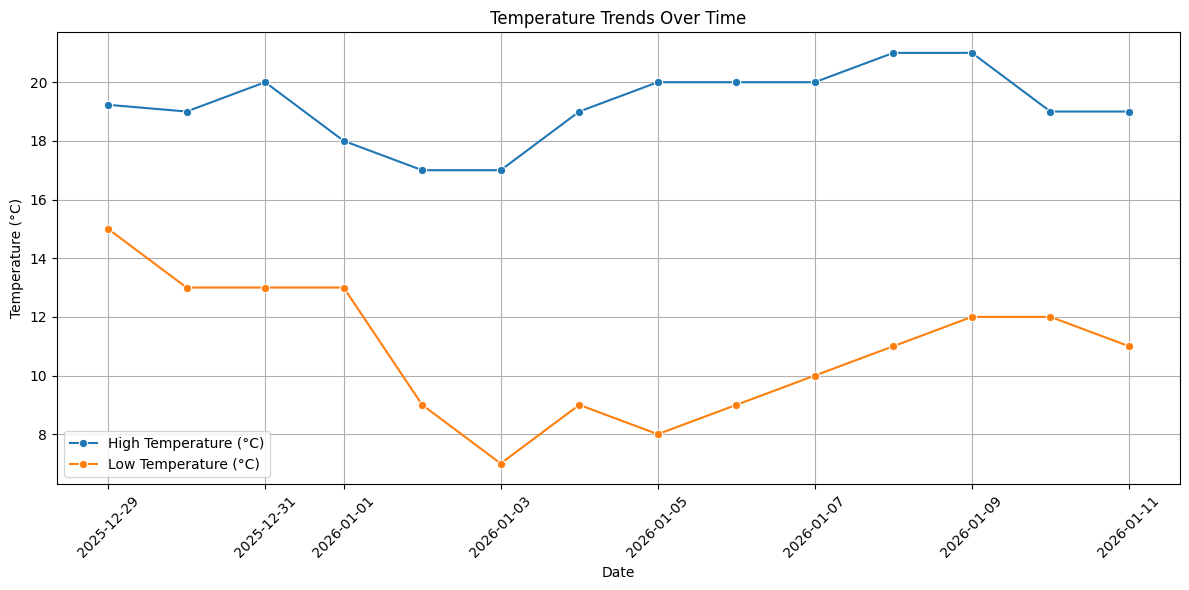

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'date' column to datetime objects for proper time series plotting
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='high_temp_c', data=df, label='High Temperature (°C)', marker='o')
sns.lineplot(x='date', y='low_temp_c', data=df, label='Low Temperature (°C)', marker='o')

# Add title and labels
plt.title('Temperature Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) # Rotate date labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [33]:
# Calculate average high and low temperatures by day of the week
average_temps_by_day = df.groupby('day_label')[['high_temp_c', 'low_temp_c']].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

print("Average High and Low Temperatures by Day of Week:")
display(average_temps_by_day.round(2))

Average High and Low Temperatures by Day of Week:


,high_temp_c,low_temp_c
day_label,,
Monday,19.62,11.5
Tuesday,19.50,11.0
Wednesday,20.00,11.5
Thursday,19.50,12.0
Friday,19.00,10.5
Saturday,18.00,9.5
Sunday,19.00,10.0


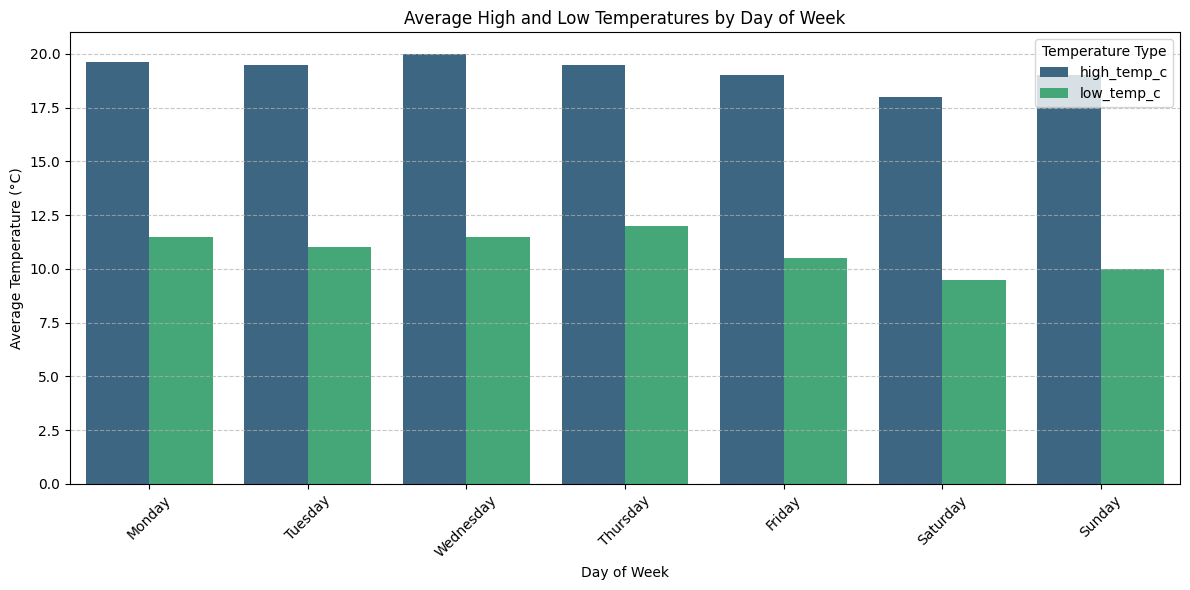

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a bar plot for average high and low temperatures by day of week
plt.figure(figsize=(12, 6))

# Melt the DataFrame to plot both high and low temperatures on the same chart
avg_temps_melted = average_temps_by_day.reset_index().melt('day_label', var_name='Temperature Type', value_name='Average Temperature (°C)')

sns.barplot(x='day_label', y='Average Temperature (°C)', hue='Temperature Type', data=avg_temps_melted, palette='viridis')

plt.title('Average High and Low Temperatures by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Temperature (°C)')
plt.legend(title='Temperature Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#4) Document Your Findings:

Create a report summarizing your methodology, analysis, and insights from the visualizations.

Explain any interesting patterns or insights derived from your data.

## Weather Data Analysis Report

### 1. Methodology: Web Scraping and Data Collection

The process began by extracting real-time weather forecast data from the BBC Weather website (`https://www.bbc.com/weather/293397`) for Tel Aviv. To achieve this, here the specific Python libraries used:

*   **Selenium**: For browser automation, allowing interaction with the dynamic content of the webpage.
Selenium was configured with a headless Chrome browser (meaning Chrome ran without a visible UI) and used `webdriver_manager` to automatically handle the Chrome driver installation, ensuring compatibility within the Colab environment.

*   **BeautifulSoup**: To parse the HTML content retrieved by Selenium and extract specific data points using CSS selectors.

The script navigated to the specified URL, waited for the relevant weather forecast elements to load, and then extracted the following information for each day in the 7-day forecast:

*   **Date**: The date of the forecast.
*   **Day Label**: The day of the week and date (e.g., "Monday 29th December").
*   **High Temperature (°C)**: The predicted maximum temperature.
*   **Low Temperature (°C)**: The predicted minimum temperature.

### 2. Data Analysis and Preprocessing

Once the data was scraped, it was loaded into a Pandas DataFrame for cleaning, preprocessing, and analysis:

1.  **Initial Inspection** of the first few rows (`df.head()`) and data type inspection (`df.info()`) to understand the structure and identify potential cleaning needs. Initially, all columns were of 'object' (string) type.
2.  **Temperature Columns Cleaning**: The 'high_temp_c' and 'low_temp_c' columns contained '°' symbols and 'N/A' strings. These were handled by:
    *   Removing '°' using `str.replace()`.
    *   Replacing 'N/A' with `np.nan` to represent missing numerical values.
    *   Converting the columns to numeric types (`float64` for high temperature and `int64` for low temperature).
    *   Filling any remaining `NaN` values with the mean of their respective columns to ensure complete numerical data.
3.  **Date and Day Label Standardization**: The 'date' and 'day_label' columns were further processed:
    *   The 'date' column, which contained values like "Mon29th", was transformed into a standardized 'DD/MM/YYYY' format, inferring the full date sequence starting from December 29, 2025.
    *   The 'day_label' column was simplified to show only the day of the week (e.g., "Monday") by extracting the first alphabetic sequence from its original string.
4.  **Basic Statistical Analysis**: After cleaning, we computed several key statistics:
    *   Average High Temperature: 19.23°C
    *   Average Low Temperature: 10.86°C
    *   Maximum High Temperature: 21.00°C
    *   Minimum High Temperature: 17.00°C
    *   Maximum Low Temperature: 15.00°C
    *   Minimum Low Temperature: 7.00°C
5.  **Correlation Analysis**: The Pearson correlation coefficient between high and low temperatures was calculated:
    *   Correlation: 0.25. This indicates a weak positive linear relationship, suggesting that while higher high temperatures generally correspond to higher low temperatures, the relationship isn't very strong, implying other factors also significantly influence daily low temperatures.

### 3. Insights from Visualizations

Two primary visualizations were generated to explore temperature trends:

1.  **Temperature Trends Over Time (Line Plot)**: This plot displayed the daily high and low temperatures across the 14-day forecast period. It clearly illustrated:
    *   **Overall Fluctuations**: Both high and low temperatures exhibit daily variations, but generally follow a similar pattern, with peaks and troughs occurring around the same dates.
    *   **Temperature Range**: The plot visually confirmed the spread between high and low temperatures each day, reinforcing the numerical statistics.

2.  **Average High and Low Temperatures by Day of Week (Bar Plot)**: This visualization provided a comparative view of average temperatures for each day of the week:
    *   **Daily Variations**: The bar chart highlighted subtle differences in average temperatures depending on the day of the week. For instance, Wednesday showed the highest average high temperature, while Saturday had the lowest average low temperature.
    *   **Consistency**: Despite the variations, the overall pattern of average high temperatures being consistently above average low temperatures was evident across all days.

### 4. Interesting Patterns and Insights

*   **Weak Positive Correlation**: The correlation coefficient of 0.25 between high and low temperatures suggests that while there's a tendency for warmer days to have warmer nights, this relationship is not very strong. This implies that other meteorological factors, such as cloud cover, humidity, or wind patterns, might play a significant role in determining nighttime temperatures independently of daytime highs.
*   **Daily Temperature Swings**: Despite the overall weak correlation, the visualizations show consistent daily temperature swings, with average high temperatures generally around 19-20°C and average lows around 10-12°C. The lowest average low temperature recorded was 9.5°C on Saturday, indicating cooler nights towards the end of the week.
*   **Mid-Week Warmth**: Wednesday stands out with the highest average high temperature (20.00°C), suggesting a warmer mid-week period in the forecast. Conversely, Saturday recorded the lowest average high temperature (18.00°C), pointing to potentially cooler daytime conditions during the weekend.

In conclusion, the data indicates a generally mild to warm forecast period for Tel Aviv with moderate daily temperature fluctuations. While high and low temperatures show a weak positive correlation, external factors likely influence the extent of nighttime cooling. The visualizations effectively highlight these trends and variations across the forecast week.